In [23]:
import sys
sys.path.append('..')
import numpy as np

from common.trainer import Trainer
from common.optimizer import Adam
from simple_cbow import SimpleCBOW

from common.layers import MatMul, SoftmaxWithLoss
from common.util import preprocess, create_contexts_target, convert_one_hot

# 3 word2vec

## 3.1 추론 기반 기법과 신경망

### 3.1.1 통계 기반 기법의 문제점

통계적 기법은 대규모 말뭉치 처리에서도 문제가 발생한다. 

통계적 기법으로 동시발생행렬을 만들고 차원 축소하여 밀집벡터로 만들어도 여전히 차원수가 크다. (단 1회의 처리)

추론기법에선 거대 말뭉치를 1번에 처리하지 않고 신경망에 미니배치로 학습시킨다. 

분포 가설에 기반하는 것은 동일하다. 

### 3.1.2 추론 기반 기법 개요

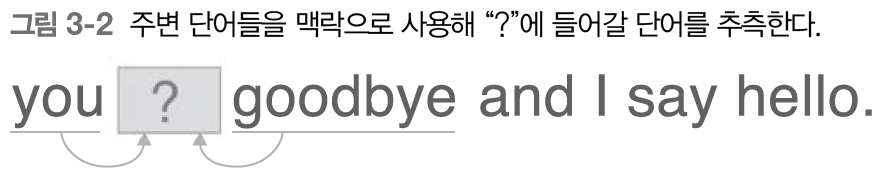

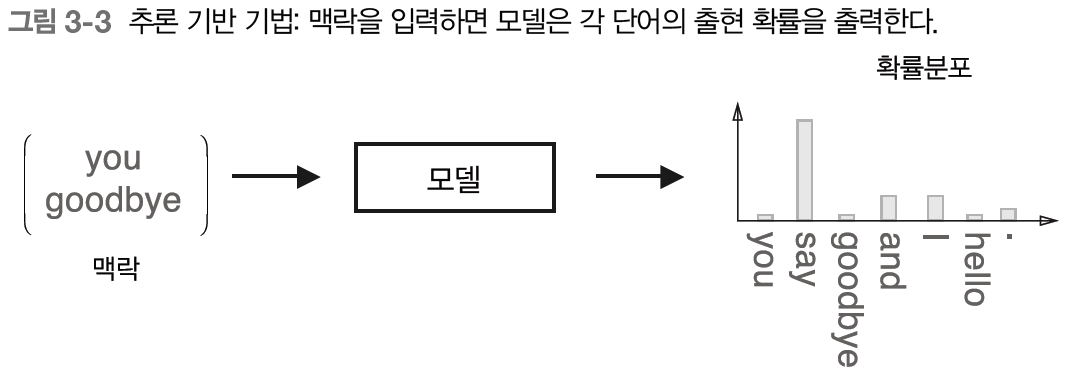

### 3.1.3 신경망에서의 단어 처리

단어를 one-hot vectorize 시킨다. 

입력층의 각 뉴런은 각 단어의 발생여부를 나타낸 자리이다. 

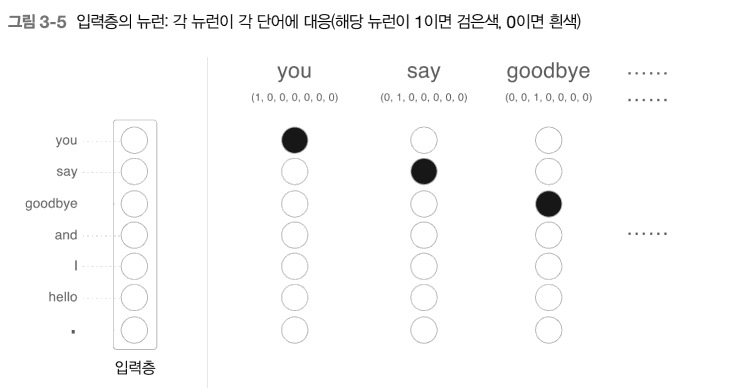

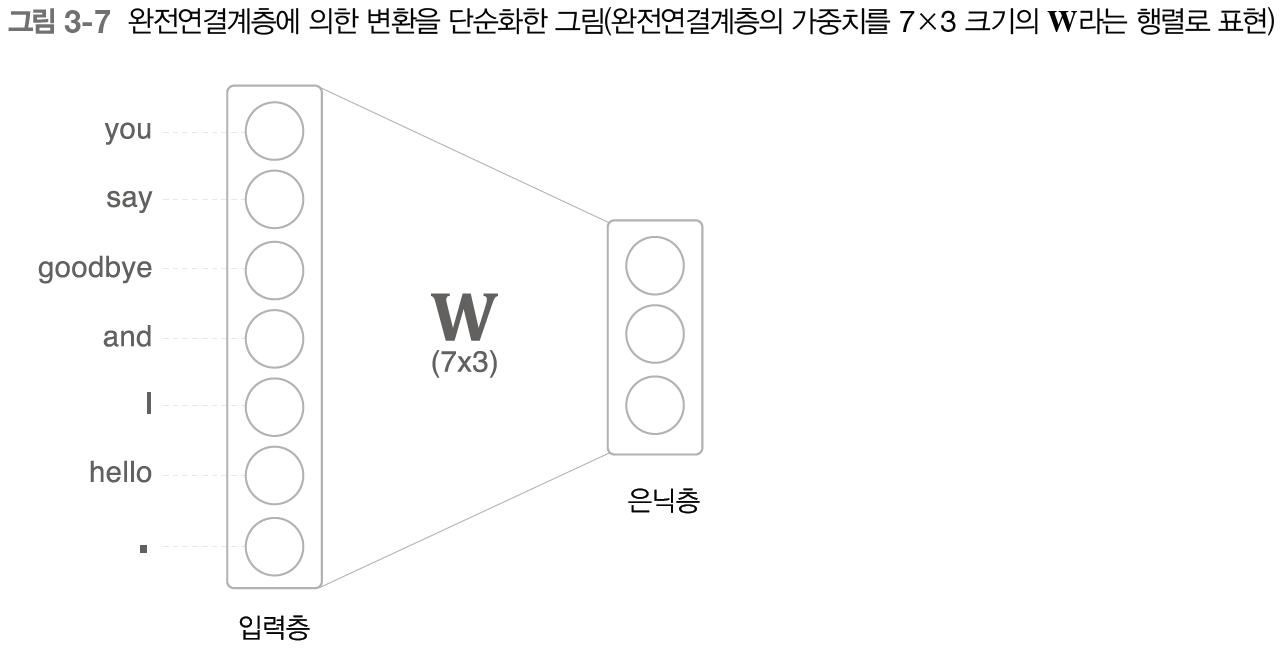

In [2]:
c = np.array([1, 0, 0, 0, 0, 0, 0])
W = np.random.randn(7, 3)
h = np.matmul(c, W) # bias 없는 fully connected layer. 
h

array([0.0373819 , 0.45809826, 0.8104309 ])

여기에서 맥락c는 one-hot vector이므로 W를 곱하면 W의 하나의 행 벡터를 뽑는 것과 같다. 

그냥 하나의 one-hot 뽑기 위해 W를 곱해주게 되므로 - 가령 [0, 1, 0, 0, 0] 을 커다란 W 에 곱해줘서 나오는게 꼴랑 W의 1번째 자리에 있는 한 줄의 가중치니까 - 비효율적으로 느껴진다. 이는 추후 개선한다. 

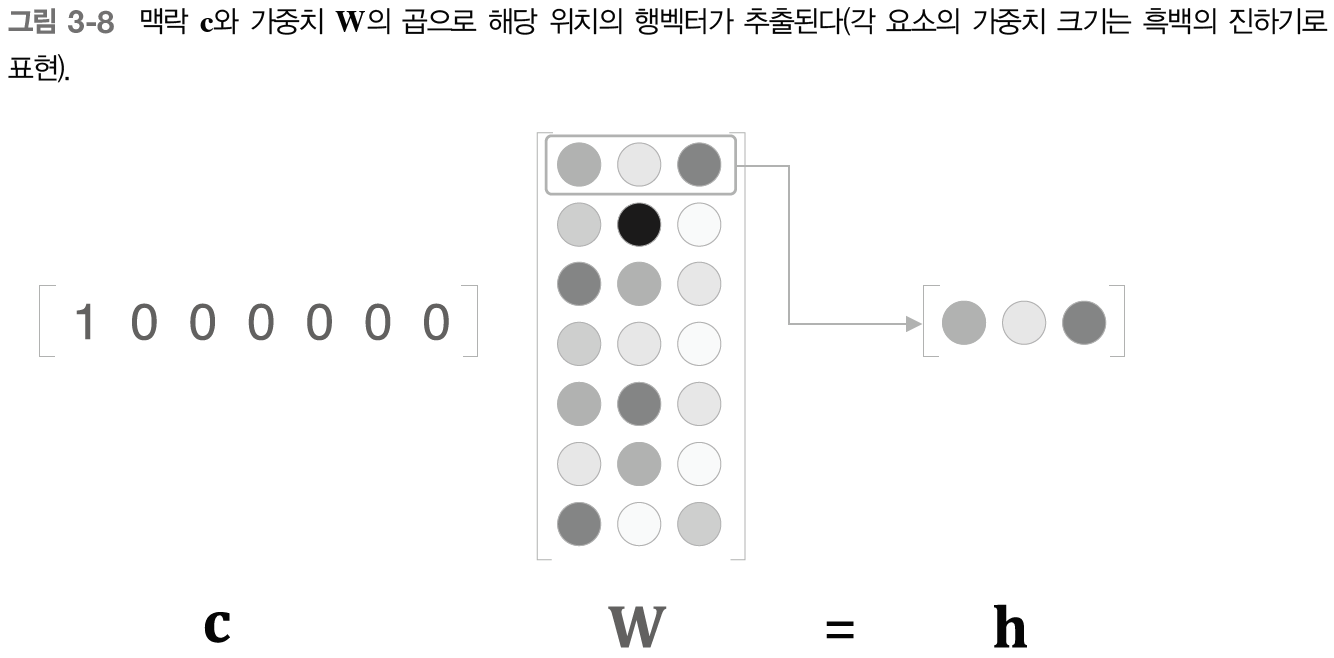

In [3]:
layer = MatMul(W)
h = layer.forward(c) # 어차피 matmul layer이다. 

h

array([0.0373819 , 0.45809826, 0.8104309 ])

## 3.2 단순한 word2vec

### 3.2.1 CBOW(Continuous Bag-Of-Words) 모델의 추론처리

CBOW는 맥락으로부터 target을 추측하는 용도의 신경망이다. (맥락: 주변 단어, target: 중앙 단어)

따라서 타깃 단어의 주변의 맥락들 (window 정한 것에 따라 얼마나 넣을지 정해짐) 을 모두 입력으로 넣는다. 

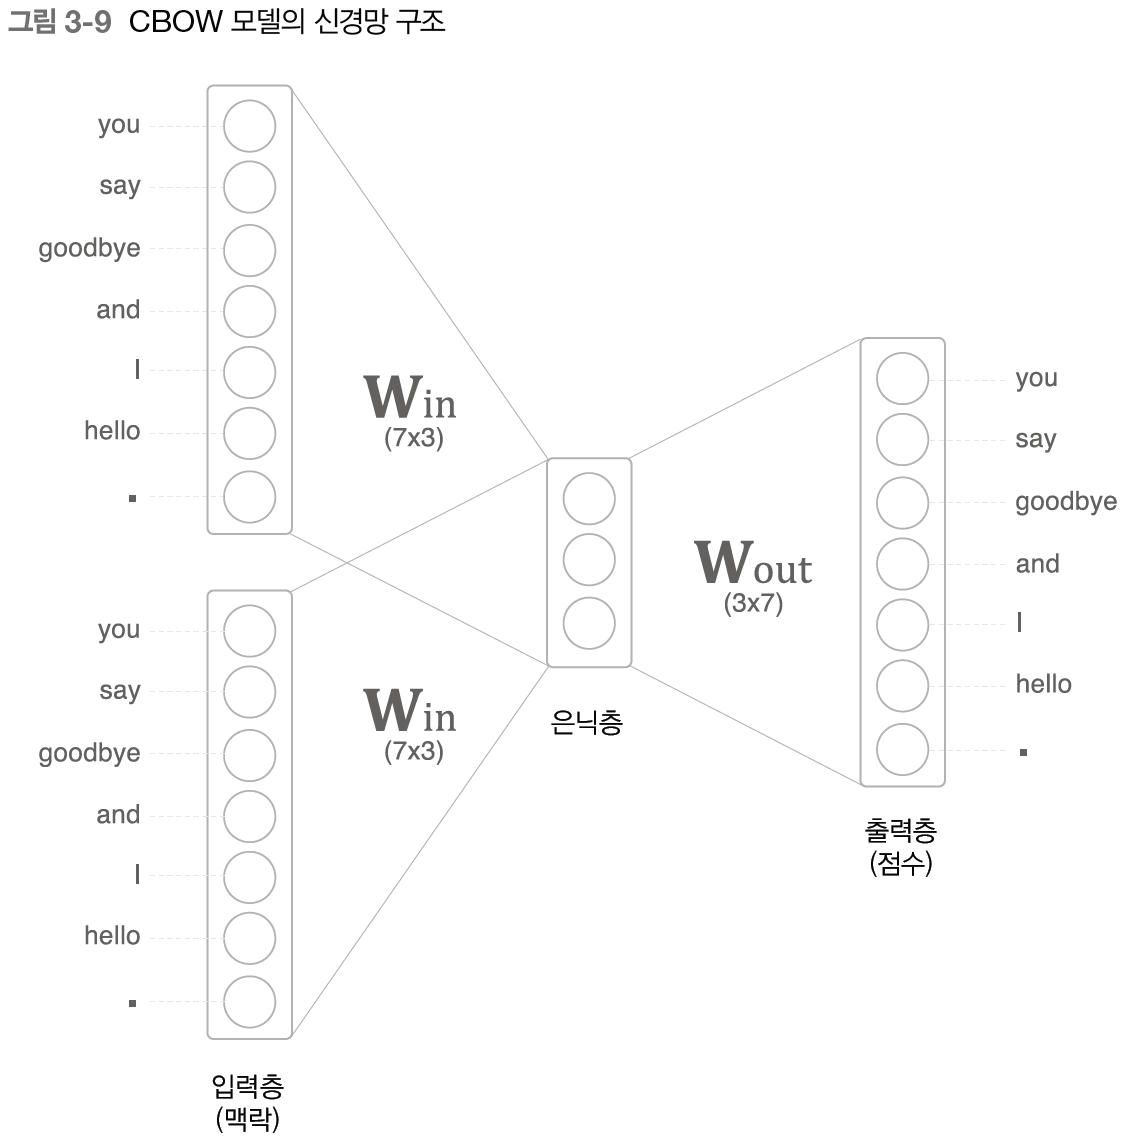

입력층의 개수는 맥락으로 고려할 단어의 개수와 같다. 

은닉층은 입력층이 여러 개일 경우 입력층들을 평균한 것이다. 

출력층에서 뉴런 하나하나는 각각의 단어에 대응한다. 각 뉴런은 '점수'를 뜻하며, 이를 소프트맥스에 넣으면 확률이 된다. 

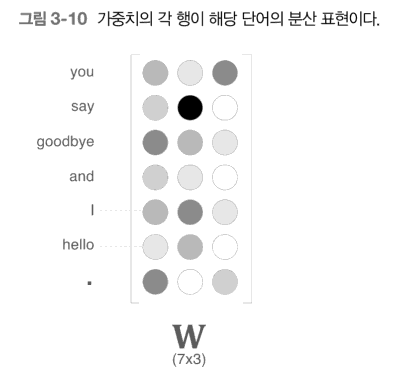

W의 각 행이 바로 단어의 분산표현이며, 학습이 진행될 수록 이 W가 정교해 지는 것이다. 

이렇게 얻은 벡터는 '단어의 의미'를 잘 녹인 상태가 된다. 이것이 바로 word2vec이다. 

여기서 중요한 것이 있다. 은닉층의 뉴런 수가 입력층의 뉴런 수보다 적게 하는 것이 매우 중요하다. 이렇게 해야 은닉층에 단어 예측에 필요한 정보를 '간결하게' 담게 되어 결과적으로 밀집벡터 표현 (dense representation) 을 얻을 수 있다. 

word2vec의 결과인 이 은닉층은 사람이 이해할 수 없는 상태이다. 인코딩 된 상태이다. 이 은닉층에서 원하는 정보를 뽑아내는 과정이 바로 디코딩에 해당한다. 

이 전체 신경망을 뉴런 관점이 아닌 계층 관점으로 나타내면 다음과 같다. 

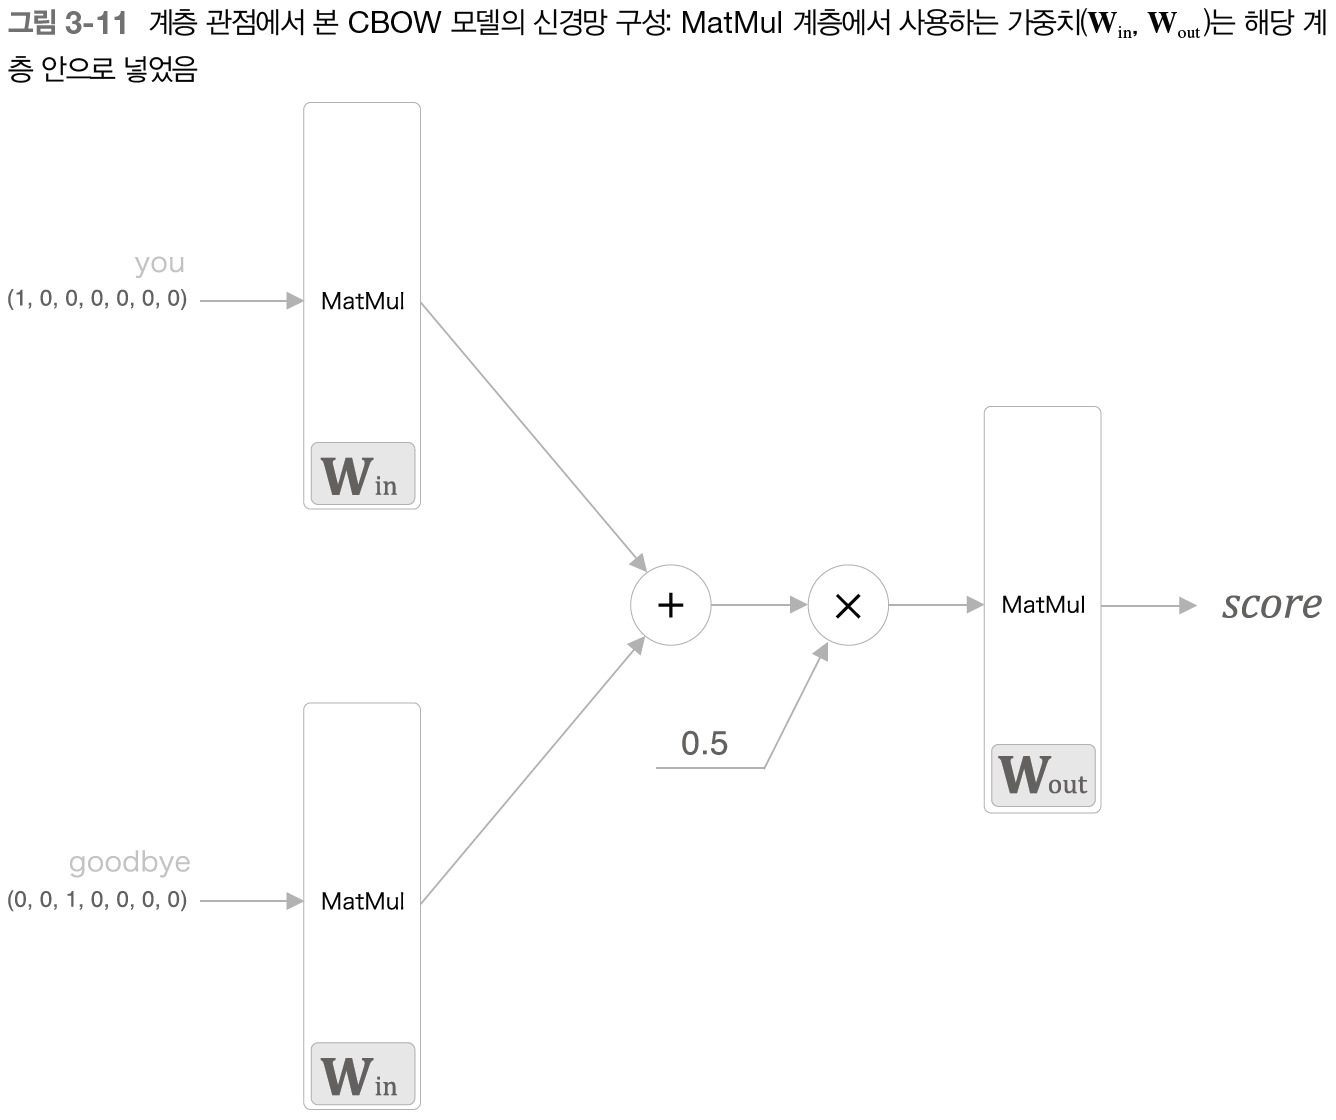

CBOW의 구현. CBOW는 활성화 함수를 사용하지 않는 간단한 구성의 신경망이다. 

In [4]:
# sample 맥락 데이터
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 가중치 초기화
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# 계층 생성: 맥락 수 만큼. 
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

s

array([[ 1.65240923,  1.57437442, -0.90177626, -1.96424477,  1.61257975,
        -0.34075357, -1.08877868]])

### 3.2.2 CBOW 모델의 학습

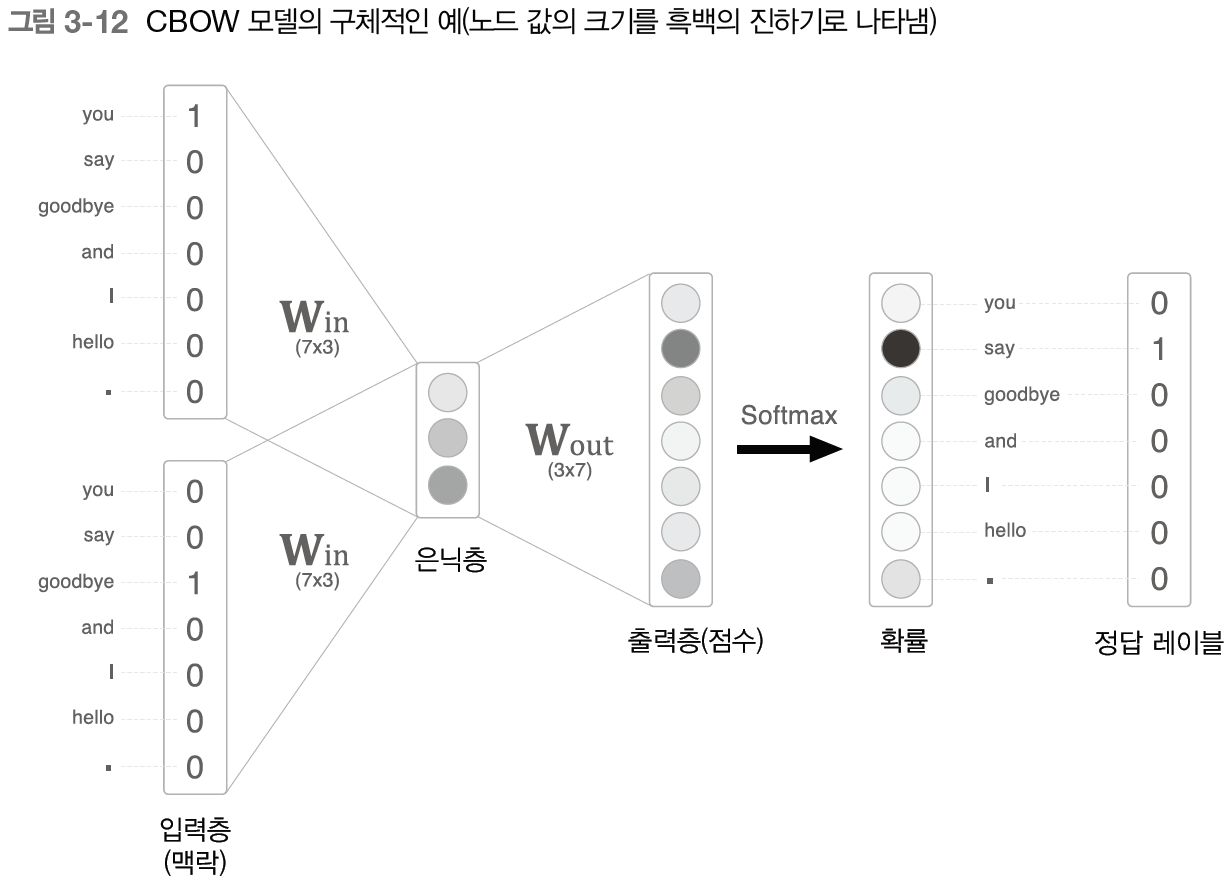

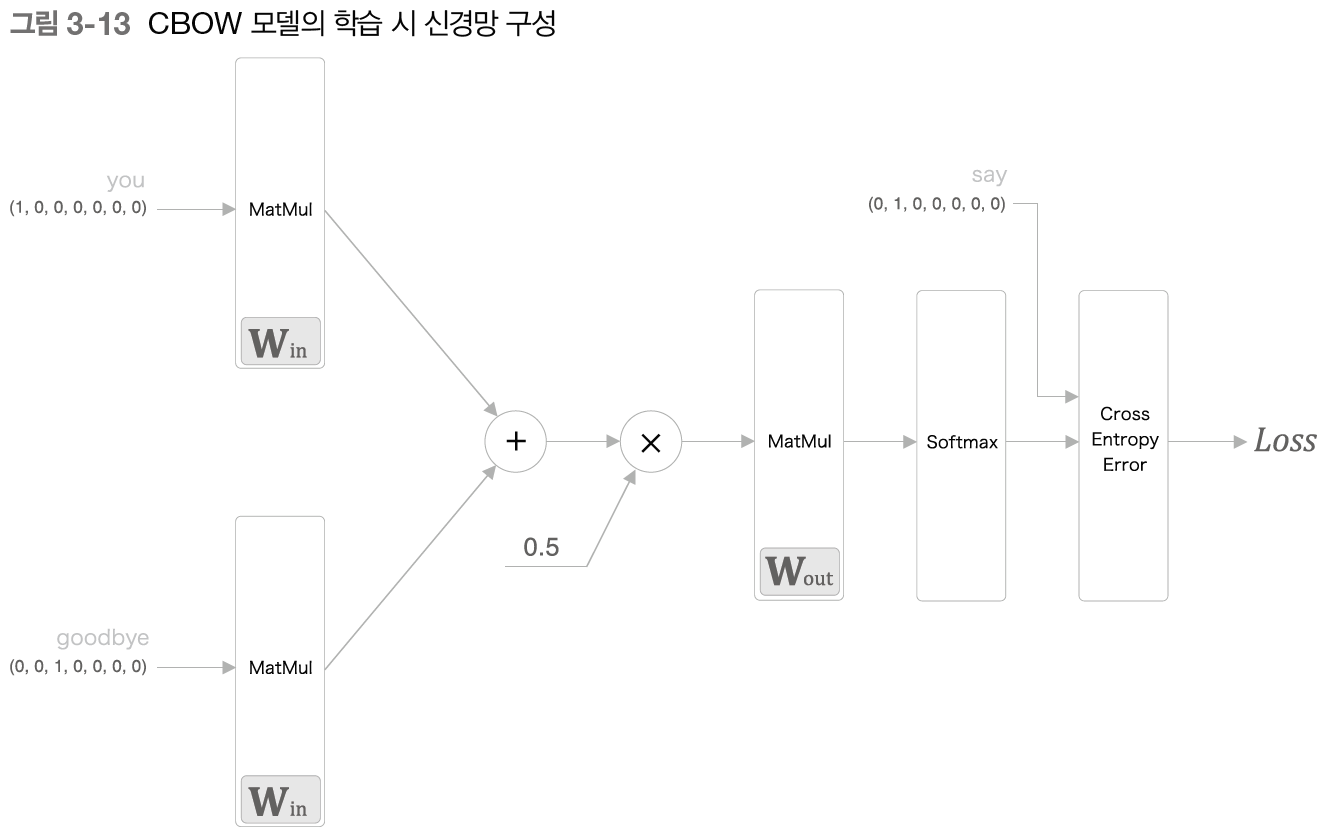

분포 가설을 사용하는 모델들의 특성 상 corpus에 민감하다. 

경제학 관련 corpus에서 학습시키는 것과 문학 corpus 학습시키는 것은 결과가 다르게 나온다. 

### 3.2.3 word2vec의 가중치와 분산 표현

W_in과 W_out 중 어떤 가중치를 word2vec으로 사용해야 할까? 보통 W_in만 사용한다. W_in은 여러 개기 때문에 이걸 어떻게 하느냐 (단순 합? 등) 에 따라서도 방법이 나뉠 수 있다. 

연구에선 주로 W_in만 단순 합 하여 사용한다. 

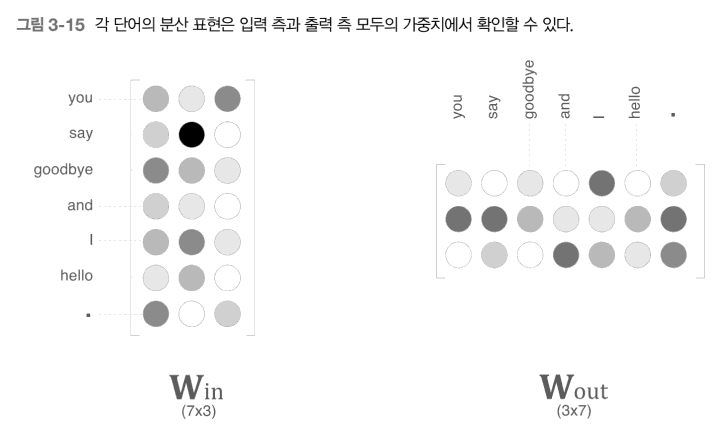

word2vec에선 입력 가중치 W_in 만 사용하지만, GloVe에선 두 가중치를 더했을 때 좋은 결과가 나왔다고 한다. 

## 3.3 학습 데이터 준비

### 3.3.1 맥락과 타깃

word2vec의 input: 맥락(contexts), output: 타깃(target) (중앙의 단어) 

이 성능을 향상시키면 된다. contexts는 보통 여러 개이므로 복수로 명시한다. 

우선 corpus text를 단어 ID로 변환한다. 

In [5]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

In [6]:
id_to_word

{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}

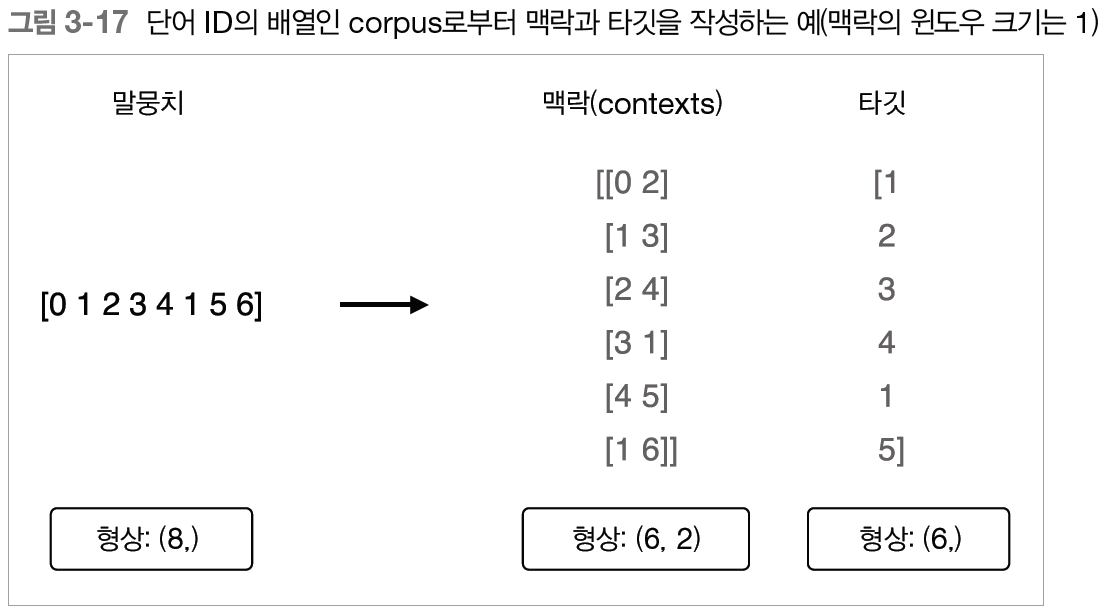

contexts는 2차원 배열이다. 

이제 contexts와 target을 만든다. 

In [7]:
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size: -window_size] # target은 중앙에 오는 단어이므로 양 끝이 window_size만큼 offset되니까 그렇다. 
    contexts = []
    
    for idx in range(window_size, len(corpus) - window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)
    
    return np.array(contexts), np.array(target)

In [8]:
contexts, target = create_contexts_target(corpus, window_size=1)

In [9]:
contexts

array([[0, 2],
       [1, 3],
       [2, 4],
       [3, 1],
       [4, 5],
       [1, 6]])

In [10]:
target

array([1, 2, 3, 4, 1, 5])

contexts: target 주위에 있는 것. 
target: 양쪽 window_size만큼 제하고 있는 나머지 contexts의 정중앙에 올 수 있는 것들 모두. 

당연한 것이다. 

아직 id로 나타나 있으므로, 이제 이를 원핫 표현으로 바꾼다. 

### 3.3.2 원핫 표현으로 변환

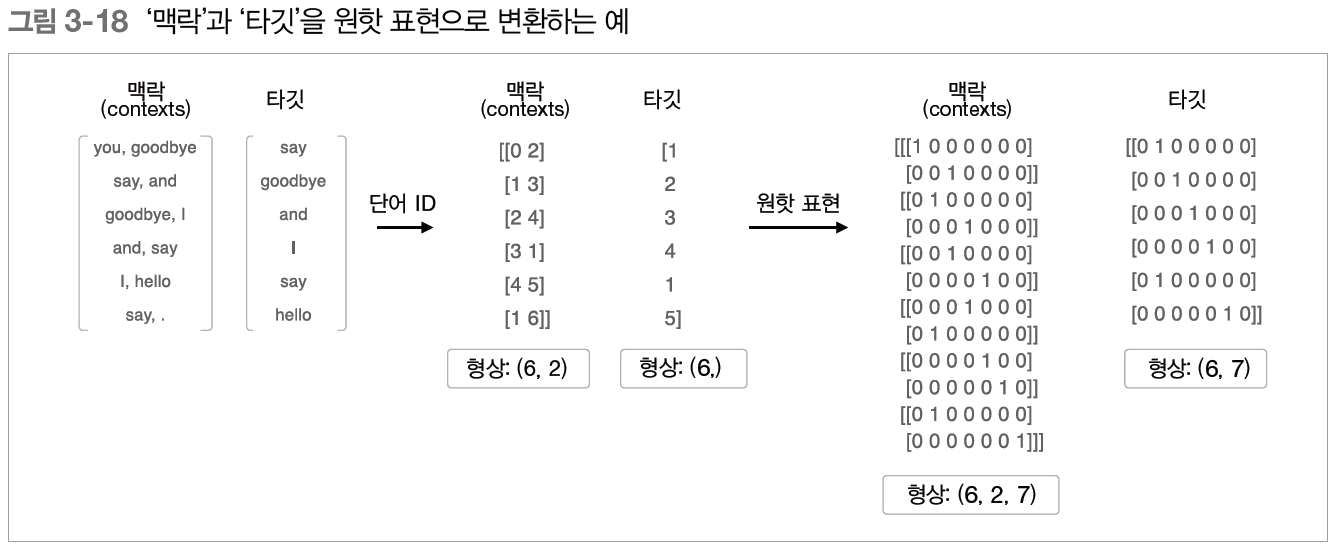

In [11]:
vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [12]:
vocab_size

7

In [13]:
target

array([[0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0]])

In [14]:
contexts

array([[[1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0]],

       [[0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0]],

       [[0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0]],

       [[0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0]],

       [[0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1]]])

In [15]:
contexts.shape 

(6, 2, 7)

- 6: 미니배치의 수
- 2: contexts의 window 크기. 즉 window 내의 단어의 수
- 7: one-hot vector의 크기

#### 이렇게 contexts는 3차원 행렬로 나온다. 

CBOW는 각 target 단어의 window 내의 단어들 = contexts를 입력으로 넣기 때문에 

contexts 내의 one-hot으로 변환된 단어들을 입력으로, 그리고 target one-hot을 출력으로 받는 네트워크를 만들 수 있고 이 네트워크를 minibatch만큼 계속 돌린다. 1번 ~ minibatch번 까지 돌리는 것이다. 

그래서 (6, 2, 7)

#### target은 이와 달리 2차원 행렬로 나온다. 

1개의 단어 one-hot가 미니배치 번 만큼 반복하기 때문이다. 

그래서 (6, 7)

## 3.4 CBOW 모델 구현

In [16]:
class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f') # 32bit 부동소수점
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        # 계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        # 모든 가중치와 기울기를 리스트에 모은다. 
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        # 인스턴스 변수에 단어의 분산 표현을 저장해준다. 
        self.word_vecs = W_in

In [17]:
def forward(self, contexts, target):
    h0 = self.in_layer0.forward(contexts[:, 0])
    h1 = self.in_layer1.forward(contexts[:, 1])
    h = (h0 + h1) * 0.5
    score = self.out_layer.forward(h)
    loss = self.loss_layer.forward(score, target)
    
    return loss

역전파도 구현한다. 

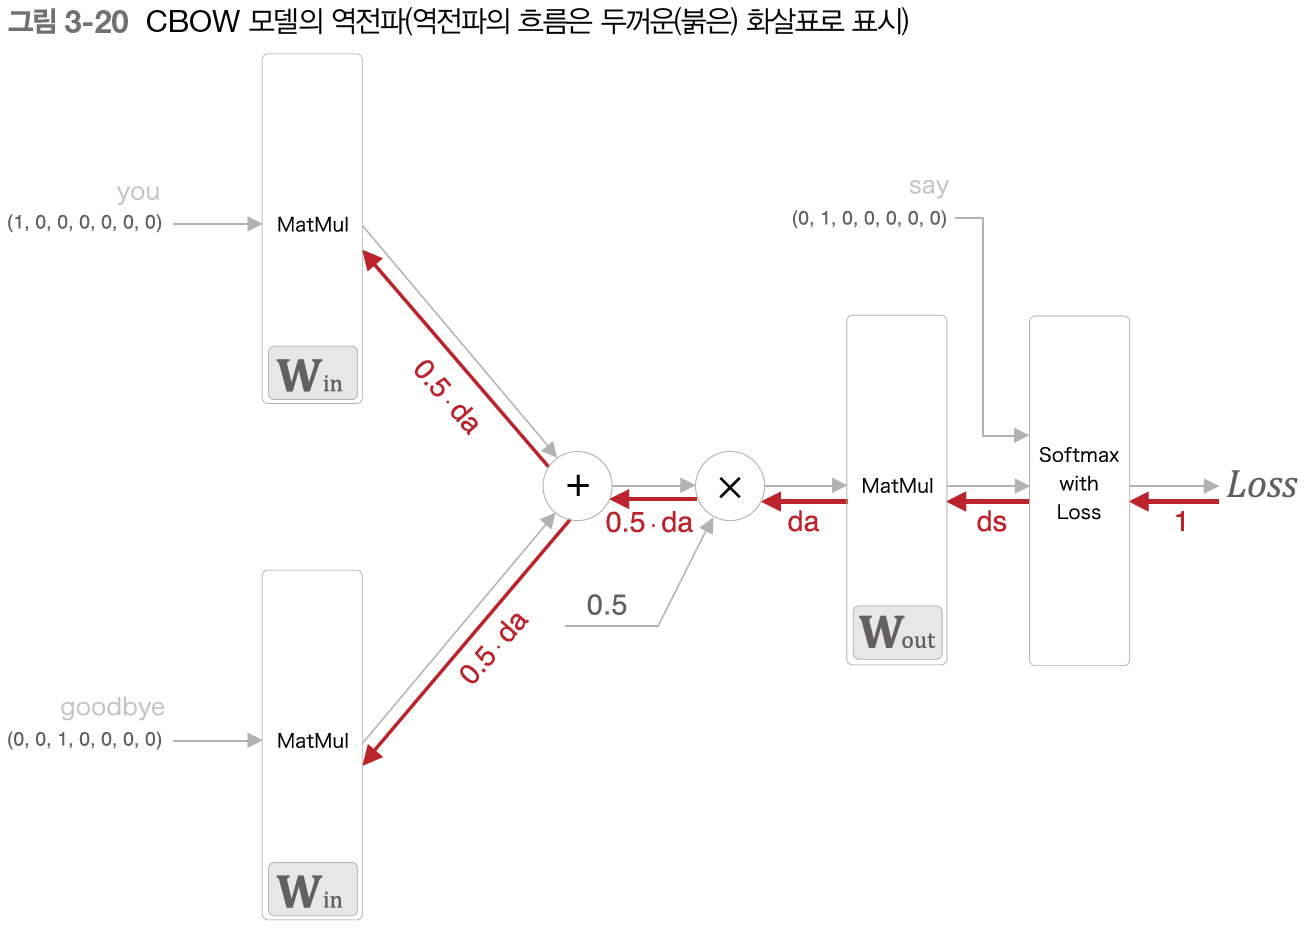

In [18]:
def backward(self, dout=1):
    ds = self.loss_layer.backward(dout)
    da = self.out_layer.backward(ds)
    da = 0.5 * da
    self.in_layer1.backward(da)
    self.in_layer0.backward(da)
    
    return

### 3.4.1 학습 코드 구현

CBOW의 학습은 일반적인 신경망 학습과 완전히 같다. 

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

C:\Users\Jaepil\Anaconda3\envs\deep_learning37\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Jaepil\Anaconda3\envs\deep_learning37\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Jaepil\Anaconda3\envs\deep_learning37\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\Jaepil\Anaconda3\envs\deep_learning37\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\Jaepil\Anaconda3\envs\deep_learning37\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Jaepil\Ana

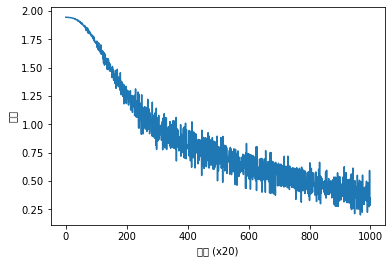

In [22]:
# 위에서 custom SimpleCBOW class를 선언했으므로 이 셀을 제대로 돌리려면 다시 SimpleCBOW를 import 하는 cell을 실행시켜야 한다. 

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

iteration이 진행될수록 Loss가 줄어드는 것을 관찰할 수 있다. 

학습이 끝난 후의 매개변수들을 살펴보자. 

단어를 밀집벡터로 나타낸 것을 볼 수 있다. 

In [24]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [-0.87218183 -0.8915125   1.7115674  -0.8980687  -0.9653084 ]
say [1.1637032  1.1554948  1.261015   1.1129464  0.22093008]
goodbye [-1.0976155 -1.0373946 -0.2747057 -1.119046  -0.8435738]
and [0.8084418  0.7928135  1.2399462  0.78600925 1.8759618 ]
i [-1.0939939  -1.0480242  -0.28501466 -1.1065125  -0.85147524]
hello [-0.90312135 -0.89350396  1.7117198  -0.89396894 -0.96611077]
. [ 1.1776503  1.1812494  0.8350808  1.1590096 -1.6827163]


## 3.5 word2vec 보충

### 3.4.1 CBOW 모델과 확률

CBOW를 확률 표기법으로 기술해보자. 

CBOW는 input으로 맥락을 주면 output으로 단어를 뱉는 것이다. 

input으로 t번째 단어 주변의 단어들을 맥락으로 주는 경우를 생각해보자. (window=1, 양 쪽으로 하나씩) 

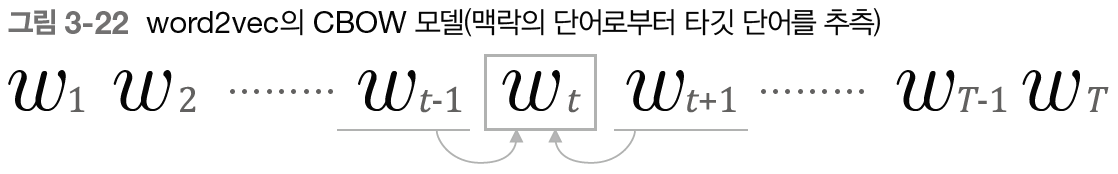

조건부 확률로 나타내면, 
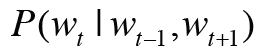

Loss function을 이로 나타내면, (한 개의 데이터에 대한 손실 함수)
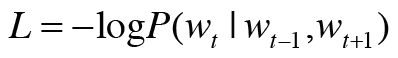 (`tk`는 원핫벡터라 없어짐.) 

이를 negative log likelihood라고 부름. 

corpus 전체로 확장하면, 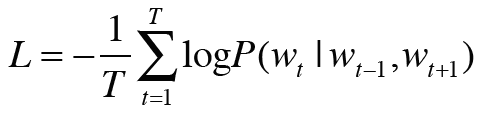

이 L을 최소화 하는 것이 CBOW모델의 역할이며, 그 결과 나온 가중치 W가 단어의 분산표현이다. 

### 3.5.2 skip-gram 모델

skip-gram은 CBOW와 반대로 맥락과 타깃을 역전시킴. 즉, 단어로 맥락을 추측. 

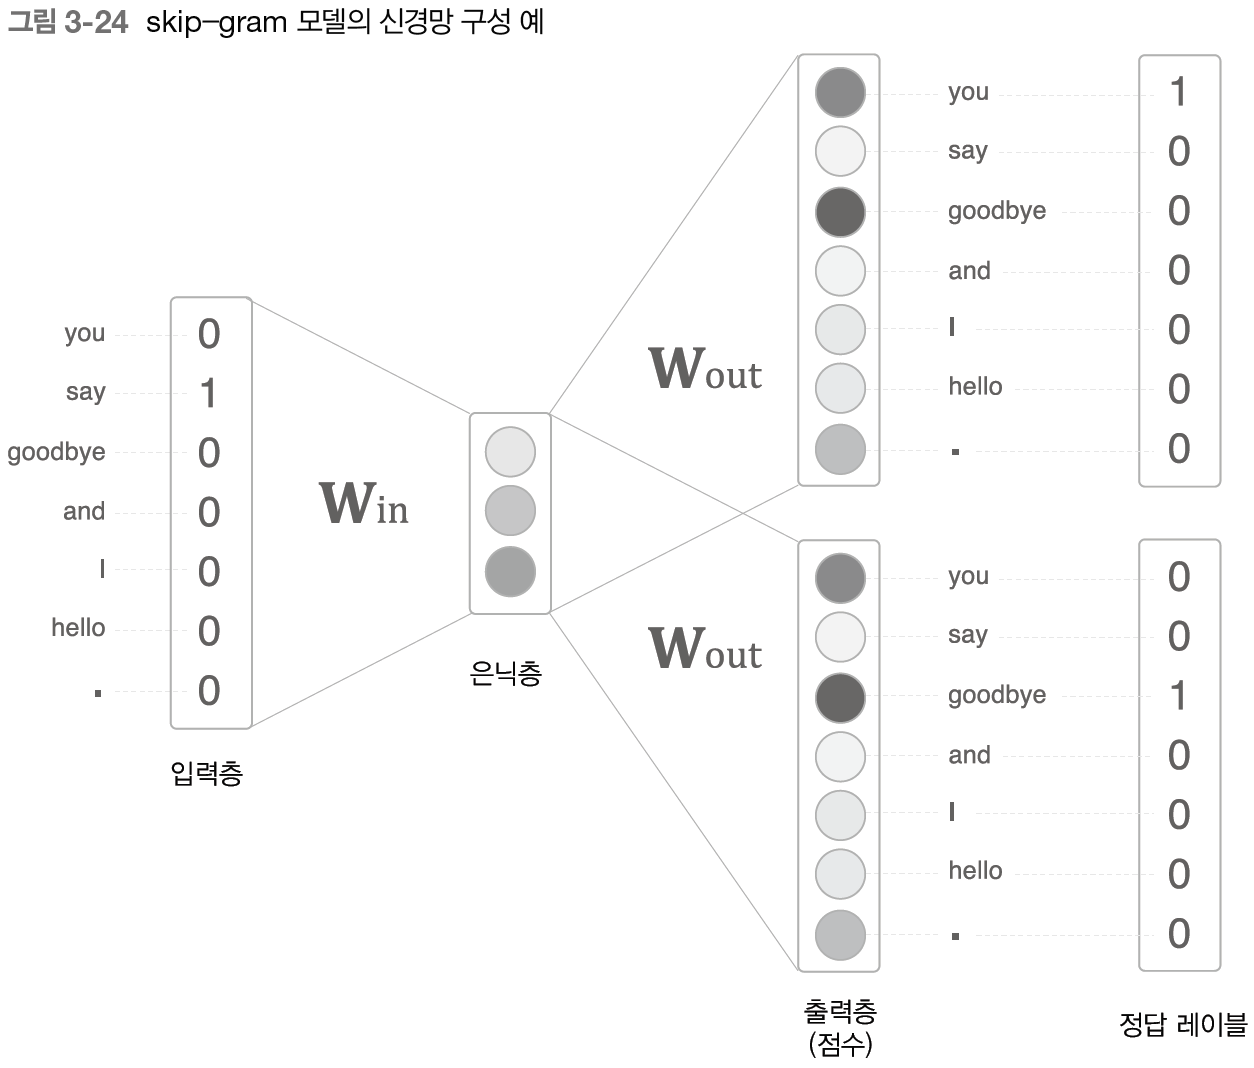

입력층은 1개 단어이다. 출력층은 맥락의 갯수만큼 있다. 각 출력층은 개별적 손실을 구하고 이 개별 손실을 모두 더한 값을 최종 손실로 쓴다. 

이를 확률표기하면 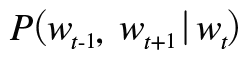 인데, 맥락 단어들 사이의 관계가 독립적이라 가정하고 다음과 같이 분해할 수 있다. (=조건부 독립, 하지만 과연 맥락 단어들 사이에 관련성이 없다고 할 수 있을까.)

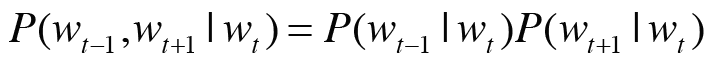 이며, 

교차 엔트로피를 적용하면 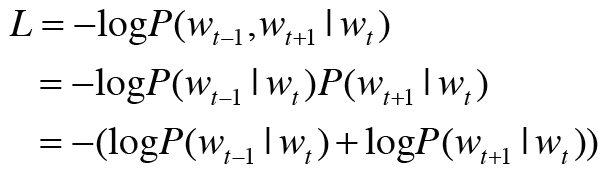

이를 corpus 전체로 확장하면 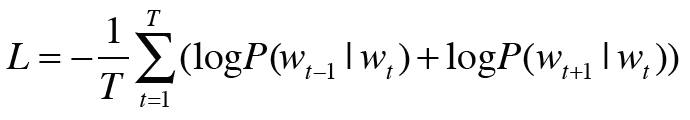

이다.

이를 CBOW의 Loss function인 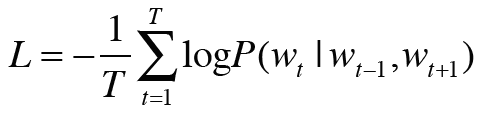 와 비교해보자. 

skip-gram은 단어로 맥락을 추측하므로 손실함수는 맥락들의 손실의 총합이다. 반대로 CBOW는 맥락으로 단어를 추측하므로 손실함수는 단어의 손실들의 총합이다. 


주로 CBOW보다 skip-gram을 쓴다. 
- 단어 분산 표현의 정밀도 면에서 나은 경우가 많다. 
- corpus가 커질수록 저빈도 단어나 유추 문제 성능 면에서 더 뛰어난 경향이 있다. 
- 하지만 학습속도는 CBOW가 더 빠르다. (skip-gram은 맥락 수만큼 구해야 해서 계산 비용이 크다)

** 나의 아이디어: 

CBOW보다 skip-gram이 나은 이유를 책에서는 skip-gram이 더 어려운 문제에 도전하기 때문이라고 추상적으로 써놨는데 아마도

I love  ____  apple 이라는 문제가 있을 때,  ____ 에는 sweet, delicious, red 등등 여러 가지가 올 수 있지만 CBOW에서는 이를 하나로 정해야 하고 

반대로 skip-gram에선 sweet가 주어졌을 때 주변 맥락의 다양한 경우의 수를 모두 고려할 수 있는 것이니까 더 복잡한 것에 대한 표현력이 좋아져 성능이 잘 나오는 것이 아닐까?

### 3.5.3 통계기반 vs 추론기반 

통계기반:
- 말뭉치 전체 통계에서 1회 학습하여 분산표현을 얻었다. 
- 새 단어가 추가될 때 계산을 처음부터 해야 한다. 
- 단어의 발생적 유사성만 기록된다. 

추론기반:
- 미니배치를 통해 여러 번 보며 학습했다. 
- 매개변수를 다시 학습할 수 있다. (학습된 가중치를 초기값으로 사용)
- 더 복잡한 패턴까지 파악되어 인코딩된다. 유추문제를 풀 수 있다. eg) king - man + woman = queen 

추론기법이 더 우월해보이지만, 실제 유사성을 정량평가해 본 결과 우열을 가릴 수 없었다는 연구도 있다. 

두 기법은 사실 연관되어있다. skig-gram, 네거티브 샘플링 모델은 모두 corpus의 cooccurance matrix를 살짝 수정한 행렬에 특수한 행렬 분해를 적용하면 같아진다. 

두 기법의 연관성을 명시적으로 융합한 GloVe 기법도 있다. 기본 아이디어는 corpus의 통계 정보를 loss function에 도입해 미니배치 학습하는 것이다. 

## 3.4 정리

- 추론 기반 기법은 추측하는 것이 목적이며, 그 부산물로 단어의 분산 표현을 얻을 수 있다. 
- word2vec은 추론 기반 기법이며, 단순한 2층 신경망이다. 
- word2vec은 skip-gram 모델과 CBOW 모델을 제공한다. 
- CBOW 모델은 여러 단어(맥락)로부터 하나의 단어(타깃)을 추측한다. 
- 반대로 skip-gram 모델은 하나의 단어(타깃)로부터 다수의 단어(맥락)를 추측한다. 
- word2vec은 가중치를 다시 학습할 수 있으므로 단어의 분산 표현 갱신이나 새로운 단어 추가를 효율적으로 수행할 수 있다. 